<a href="https://colab.research.google.com/github/michelegaruti/Thesis-2021-Garuti/blob/main/FinalThesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import modules here
import pandas as pd
import numpy as np
import gdown
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from sklearn.model_selection import train_test_split


'!pip install scikit-learn==0.23.1\n!pip install imbalanced-learn==0.7.0'

In [ ]:
#Time Aware layer for T_LSTM models:
'''
TLSTM_layer is obtained from the following Github Repository:

Nguyen, A., Chatterjee, S., Weinzierl, S., Schwinn, L., Matzner, M., & Eskofier, B.(2020).
Time matters: Time-aware lstms for predictive business processmonitoring; TLSTM_layer [Source Code]. Retrievable at:
https://github.com/annguy/time-aware-pbpm/blob/master/src/Models/TLSTM_layer.py. [Accessed on May 21st, 2021]

The MIT License (MIT)
Copyright (c) 2020, An Nguyen, Srijeet Chatterjee

Permission is hereby granted, free of charge, to any person obtaining a copy of 
this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation the rights to use,
copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies
or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED
TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.
IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY,
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE
OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

Link for detailed installation instructions of conda environment: https://github.com/annguy/time-aware-pbpm
'''
!pip install kora -q
from kora import drive
drive.link_nbs()
import import_ipynb
import src
from src import TLSTM_layer

In [ ]:
#Dataset
'''
The full dataset can be downloaded following this Github link:

Requena, B., Cassani, G., Tagliabue, J., Greco, C., & Lacasa, L. (2020).
Shopper intentprediction from clickstream e-commerce data with minimal browsing information.
https://github.com/coveooss/shopper-intent-prediction-nature-2020
'''
df = pd.read_csv('./release_10_23_2020.csv')

In [ ]:
## Pre-processing function
def preprocess(df):

  # rename actions
  df['product_action'] = df['product_action'].replace([np.nan,'detail', 'add', 'remove', 'click', 'purchase',],[1,2,3,4,5,7])

  # make sequences
  df = df.groupby('session_id_hash')[['product_action', 'server_timestamp_epoch_ms']].agg(list).reset_index()

  #make labels
  df['label'] = np.where(df.product_action.map(set([7]).issubset), 0, 1)
  
  #trim sequences after first purchase event
  def trim(df):
    sequence_action = []
    timestamp = []
    for item, time in zip(df.product_action, df.server_timestamp_epoch_ms):
      if 7 in set(item):
        for e in range(len(item)):
          if item[e] == 7:
            item1 = item[: e]
            sequence_action.append(item1)
            time1 = time[: e] 
            timestamp.append(time1)
            break
      else:
        sequence_action.append(item)
        timestamp.append(time)
    df['sequence_action'] = sequence_action
    df['timestamp'] = timestamp
    return df
  trim(df)

  #rearrange column order and drop old product_action column
  df = df[['session_id_hash', 'sequence_action', 'timestamp', 'label']]

  #drop sequences shorter than 5 and longer than 155
  index_to_drop = []
  for id, row in df.iterrows():
    if len(row[1]) < 5 or len(row[1]) > 155:
      index_to_drop.append(id)
  df = df.drop(df.index[index_to_drop])

  #add exit event
  def add_exit(df):
    sequence_exit = []
    for id, row in df.iterrows():
      row[1] = [0] + row[1] + [6]
      sequence_exit.append(row[1])
    df['sequence_exit'] = sequence_exit
    return df
  add_exit(df)

  # add durations
  def delta(df):
    delta = []
    for t in df['timestamp']:
      v = [0] + list(np.diff([t[0]] + t))
      v = np.asarray(v)
      delta.append(v)
    df['delta'] = delta
    return df
  delta(df)
  
  #reset index
  df = df[['session_id_hash', 'sequence_exit', 'timestamp', 'delta', 'label']]
  df = df.reset_index()
  df.drop('index', inplace=True, axis=1)

  return df


In [ ]:
### Preprocess Dataframe
df2 = preprocess(df)

In [ ]:
df2

,session_id_hash,sequence_exit,timestamp,delta,label
0,00007d15aeb741b3cdd873cb3933351d699cc320,"[0, 1, 1, 2, 1, 2, 1, 2, 6]","[1544908835402, 1544908847263, 1544909035879, ...","[0, 0, 11861, 188616, 14067, 181642, 40819, 62...",1
1,00014c4428e61aca7e64be1064d2b6cf49233cfb,"[0, 1, 1, 1, 1, 1, 1, 2, 5, 1, 2, 1, 1, 1, 1, ...","[1545550515947, 1545550562911, 1545550685332, ...","[0, 0, 46964, 122421, 18479, 5551, 10477, 9164...",1
2,00024193b68493dc098deb8a7d074ae438c615af,"[0, 1, 1, 2, 5, 1, 6]","[1545035634176, 1545035642856, 1545035665242, ...","[0, 0, 8680, 22386, 8, 8628]",1
3,00033ce5ea7a3c31c62320c4631860fcf638f5b3,"[0, 1, 1, 2, 1, 2, 1, 2, 1, 6]","[1545133756068, 1545133781992, 1545133945223, ...","[0, 0, 25924, 163231, 8779, 35520, 13783, 1518...",1
4,0003537cea83b232652aa2d29f90fec46e523443,"[0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 6]","[1544880442310, 1544880482619, 1544880489778, ...","[0, 0, 40309, 7159, 64899, 28374, 31856, 20089...",1
...,...,...,...,...,...
203079,ffff38a875f9ac9e1b5b856ffedc0a4138b33911,"[0, 1, 2, 1, 4, 1, 2, 1, 2, 1, 2, 6]","[1544867029115, 1544867677912, 1544867707956, ...","[0, 0, 648797, 30044, 5634, 7905, 27698, 18326...",1
203080,ffff53cb919d6e46ea7cf956124d42dda833e9a2,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6]","[1544398735741, 1544398752899, 1544398789200, ...","[0, 0, 17158, 36301, 13857, 14530, 24767, 4422...",1
203081,ffff994e0a8b2fbcef28215c9a5f3ccc564f397b,"[0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 6]","[1544474002066, 1544474094102, 1544474094418, ...","[0, 0, 92036, 316, 5709, 7147, 3967, 659865, 5...",1
203082,ffffac40fa299e3832c53a3c07d3e1b8e495ab5a,"[0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 6]","[1544652731098, 1544653058871, 1544653065524, ...","[0, 0, 327773, 6653, 115874, 32848, 1244724, 1...",1


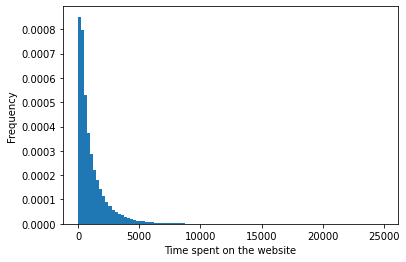

In [ ]:
#Time plost
average_time_on_site = []
for row in df2['timestamp']:
  average_time_on_site.append(row[-1]-row[0])

plt.hist(average_time_on_site, density=True, bins=100)  # density=False would make counts
plt.ylabel('Frequency')
plt.xlabel('Time spent on the website');

Text(0.5, 1.0, 'Average time between consecutive actions')

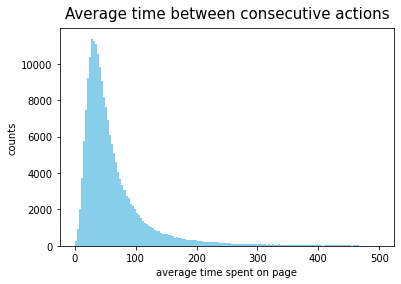

In [ ]:
#TSP plot
average_time_on_site = np.asarray(average_time_on_site)
average_time_on_site= average_time_on_site/1000
average_duration = []
for row in df2['delta']:
  row = np.asarray(row[2:])
  mean = np.mean(row)
  if mean < 500:
    average_duration.append(mean)
average_duration = np.asarray(average_duration)
plt.hist(average_duration, density=False, bins=150, color = "skyblue", )  # density=False would make counts
plt.ylabel('counts')
plt.xlabel('average time spent on page');
plt.title("Average time between consecutive actions", size = 15, pad = 10)

In [ ]:
print(np.mean(average_duration))
print(np.std(average_duration))
print(max(average_duration))

63.775401233595474
60.40528630371501
1159.98775


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  


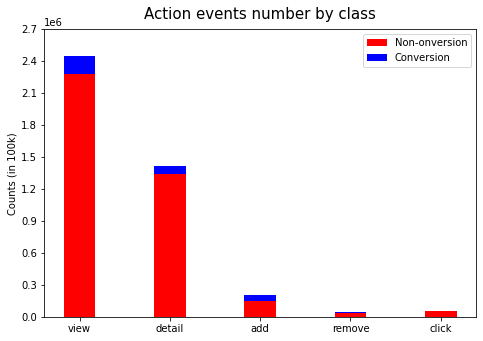

In [ ]:
#Bar plot
view_c = 0
detail_c= 0
add_c= 0
remove_c= 0
click_c= 0
view_nc= 0
detail_nc= 0
add_nc= 0
remove_nc= 0
click_nc= 0
for id, row in df2.iterrows():
  if row[4]==0:
    for i in row[1]:
      if i == 1:
        view_c +=1
      elif i == 2:
        detail_c +=1
      elif i == 3:
        add_c +=1
      elif i == 4:
        remove_c +=1
      elif i == 5:
        click_c +=1
  elif row[4]==1:
    for i in row[1]:
      if i == 1:
        view_nc +=1
      elif i == 2:
        detail_nc +=1
      elif i == 3:
        add_nc +=1
      elif i == 4:
        remove_nc +=1
      elif i == 5:
        click_nc +=1
import numpy as np
import matplotlib.pyplot as plt

conversion = (view_c,detail_c,add_c,remove_c,click_c)
non_conversion = (view_nc,detail_nc,add_nc,remove_nc,click_nc)
ind = ('view','detail','add','remove','click') # the x locations for the groups
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, non_conversion, width, color='r')
ax.bar(ind, conversion, width,bottom=non_conversion , color='b')
ax.set_ylabel('Counts (in 100k)')
ax.set_title('Action events number by class',size = 15, pad = 10)
ax.set_xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_yticks(np.arange(0, 3000000, 300000))
ax.legend(labels=['Non-onversion', 'Conversion'])
plt.show()

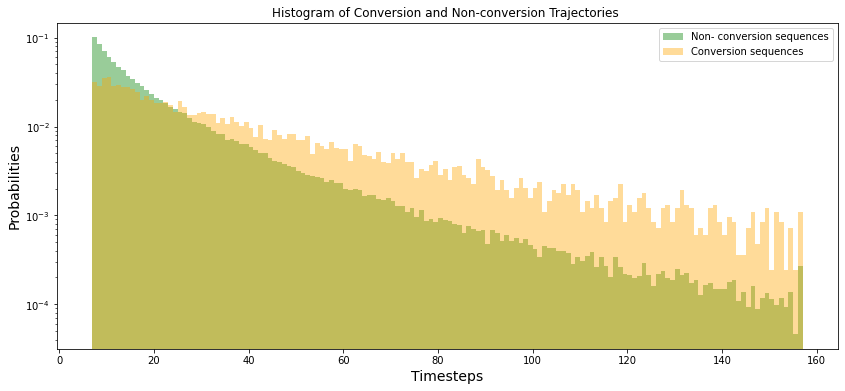

In [ ]:
## histogram
length_sequences_C = []
length_sequences_NC = []

tot0 = df2[df2['label'] == 0].shape[0]
tot1 = df2[df2['label'] == 1].shape[0]

for item, y in zip(df2.sequence_exit, df2.label):
  if y == 0:
    length_sequences_C.append(len(item))
  else:
    length_sequences_NC.append(len(item))

plt.figure(figsize=(14,6))

plt.hist(length_sequences_NC, bins=150, alpha=0.4, label="Non- conversion sequences", density=True, color = "g")
plt.hist(length_sequences_C, bins=150, alpha=0.4, label="Conversion sequences", density=True, color = "orange")

plt.yscale('log')
plt.xlabel("Timesteps", size=14)
plt.ylabel("Probabilities", size=14)
plt.title("Histogram of Conversion and Non-conversion Trajectories ")
plt.legend(loc='upper right')
#plt.savefig("overlapping_histograms_with_matplotlib_Python.png")

1    194755
0      8329
Name: label, dtype: int64

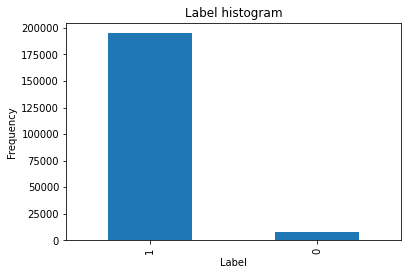

In [ ]:
pd.value_counts(df_1['label']).plot.bar()
plt.title('Label histogram')
plt.xlabel('Label')
plt.ylabel('Frequency')
df_1['label'].value_counts()

In [ ]:
#pad sequences
from keras.preprocessing.sequence import pad_sequences
import sklearn
import numpy as np
from keras.utils import to_categorical

num_classes = 7
maxlen = 157

X1 = []
for sequence in df2['sequence_exit']:
  X1.append(to_categorical(sequence, num_classes = num_classes))
lol = X1
X1 = pad_sequences(X1, maxlen = maxlen, value = 0)
X2 = pad_sequences(df2['delta'], maxlen -1, value = -1)
X3 = df2['timestamp']

new_X = []
new_y = []
for x in X1:
  new_X.append(x[:-1])
  new_y.append(x[1:])

new_X = np.asarray(new_X)
new_y = np.asarray(new_y)


X = pd.DataFrame({'new_X': list(new_X), 'X2': list(X2), 'X3': list(X3), 'new_y': list(new_y)}, columns=['new_X', 'X2', 'X3', 'new_y'])

y = df2['label']

In [ ]:
#holdout method
from sklearn.model_selection import train_test_split

X_train1, X_val1, y_train1, y_val1 = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_val1, y_val1, test_size=0.5, random_state=42, stratify = y_val1)

In [ ]:
#label sets

from numpy import where
from collections import Counter


y_train = pd.DataFrame()
y_train['new_y'] = X_train1['new_y']

y_train['y_label'] = y_train1

y_val = pd.DataFrame()
y_val['new_y'] = X_val2['new_y']

y_val['y_label'] = y_val2

y_test = pd.DataFrame()
y_test['new_y'] = X_test2['new_y']

y_test['y_label'] = y_test2

# summarize the new class distribution
counter = Counter(y_train)


In [ ]:
#reshape all data
X_train_new = np.stack(X_train1['new_X']).reshape((len(X_train1['new_X']), (maxlen -1 ) , num_classes)).astype(np.float32)
X_val_new = np.stack(X_val2['new_X']).reshape((len(X_val2['new_X']), (maxlen -1 ), num_classes)).astype(np.float32)
X_test_new = np.stack(X_test2['new_X']).reshape((len(X_test2['new_X']), (maxlen -1), num_classes)).astype(np.float32)
X_train_delta = np.stack(X_train1['X2']).reshape((len(X_train1['X2']), maxlen-1)).astype(np.float32)
X_val_delta = np.stack(X_val2['X2']).reshape((len(X_val2['X2']),maxlen -1)).astype(np.float32)
X_test_delta = np.stack(X_test2['X2']).reshape((len(X_test2['X2']),maxlen -1)).astype(np.float32)
X_train_time = np.asarray(X_train1['X3'])
X_val_time = np.asarray(X_val2['X3'])
X_test_time = np.asarray(X_test2['X3'])

y_train_label = y_train['y_label']
y_val_label = y_val['y_label']
y_test_label = y_test['y_label']

y_train_new = np.stack(y_train['new_y']).reshape((len(y_train['new_y']), (maxlen -1 ), num_classes)).astype(np.float32)
y_val_new = np.stack(y_val['new_y']).reshape((len(y_val['new_y']), (maxlen -1), num_classes)).astype(np.float32)
y_test_new = np.stack(y_test['new_y']).reshape((len(y_test['new_y']), (maxlen -1 ), num_classes)).astype(np.float32)

In [ ]:
print(X_train_new.shape)
print(X_val_new.shape)
print(X_test_new.shape)
print('---------------')
print(X_train_delta.shape)
print(X_val_delta.shape)
print(X_test_delta.shape)
print('---------------')
print(y_train_new.shape)
print(y_val_new.shape)
print(y_test_new.shape)

(142158, 156, 7)
(30463, 156, 7)
(30463, 156, 7)
---------------
(142158, 156)
(30463, 156)
(30463, 156)
---------------
(142158, 156, 7)
(30463, 156, 7)
(30463, 156, 7)


In [ ]:
#Discriminative specialised LSTM
from keras.layers import LSTM, Dense, Masking, Input, BatchNormalization
from keras import  Model

main_input = Input(shape=(maxlen -1, num_classes), name='main_input')
mask = Masking(mask_value = [0.,0.,0.,0.,0.,0.,0.], name = 'mask' )(main_input)
# train a 2-layer LSTM with one shared layer
l1 = LSTM(64, return_sequences=True)(mask)  # the shared layer
b1 = BatchNormalization()(l1)

l2_1 = LSTM(64, return_sequences=False)(b1)  # the layer specialized in activity prediction
b2_1 = BatchNormalization()(l2_1)

binary_output = Dense(1, activation='sigmoid', name='binary_output')(b2_1)

model_SD = Model(inputs=[main_input], outputs=[binary_output])

model_SD.compile(loss= 'binary_crossentropy',optimizer = 'adam', metrics = ['acc'])

In [ ]:
#Fit model
batch_size = 64
epochs = 5
history_SD = model_SD.fit(X_train_new, y_train_label,
                         validation_data = (X_val_new, y_val_label),
                         verbose=1,
                         batch_size=batch_size,
                         epochs=epochs)

Epoch 1/5
2222/2222 [==============================] - 765s 341ms/step - loss: 0.1958 - acc: 0.9365 - val_loss: 0.0869 - val_acc: 0.9611
Epoch 2/5
2222/2222 [==============================] - 747s 336ms/step - loss: 0.0784 - acc: 0.9654 - val_loss: 0.0783 - val_acc: 0.9674
Epoch 3/5
2222/2222 [==============================] - 746s 336ms/step - loss: 0.0784 - acc: 0.9655 - val_loss: 0.0782 - val_acc: 0.9668
Epoch 4/5
2222/2222 [==============================] - 742s 334ms/step - loss: 0.0791 - acc: 0.9659 - val_loss: 0.0767 - val_acc: 0.9682
Epoch 5/5
2222/2222 [==============================] - 744s 335ms/step - loss: 0.0775 - acc: 0.9666 - val_loss: 0.0785 - val_acc: 0.9659


In [ ]:
# model predict
y_pred_binary_SD = model_SD.predict(X_test_new)

In [ ]:
#save model
model_SD.save('model_SD.h5')

In [ ]:
#load model
model_SD = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Thesis/model_SD.h5')

In [ ]:
#TIME generative specialised TIME LSTM
from keras.layers import LSTM, Dense, Masking, Input, BatchNormalization
from keras import  Model
from src import TLSTM_layer
main_input = Input(shape=(maxlen -1, num_classes), name='main_input')
mask1 = Masking(mask_value = 0, name = 'mask1' )(main_input)
# delta_ts: (batch_size, 1)
delta_ts = Input(shape=(maxlen -1, ), name='delta_ts')
mask2 = Masking(mask_value = -1, name = 'mask2' )(delta_ts)
# train a 2-layer LSTM with one shared layer
l1 = TLSTM_layer(64, return_sequence=True)(mask1,mask2)  # the shared layer
b1 = BatchNormalization()(l1)

l2_1 = TLSTM_layer(64, return_sequence=True)(b1,mask2)  # the layer specialized in activity prediction
b2_1 = BatchNormalization()(l2_1)

act_output = Dense(num_classes, activation='softmax', name='act_output')(b2_1)

time_model_SG = Model(inputs=[main_input, delta_ts], outputs=[act_output])

time_model_SG.compile(loss= 'categorical_crossentropy',optimizer = 'adam', metrics = ['acc'])

In [ ]:
#Fit model
batch_size = 64
epochs = 5
history_time_SG = time_model_SG.fit([X_train_new, X_train_delta], y_train_new,
                         validation_data = ([X_val_new, X_val_delta], y_val_new),
                         verbose=1,
                         batch_size=batch_size,
                         epochs=epochs)

Epoch 1/5
2222/2222 [==============================] - 908s 406ms/step - loss: 0.1162 - acc: 0.6957 - val_loss: 0.1014 - val_acc: 0.7291
Epoch 2/5
2222/2222 [==============================] - 891s 401ms/step - loss: 0.0995 - acc: 0.7281 - val_loss: 0.1006 - val_acc: 0.7286
Epoch 3/5
2222/2222 [==============================] - 894s 403ms/step - loss: 0.0992 - acc: 0.7281 - val_loss: 0.0994 - val_acc: 0.7315
Epoch 4/5
2222/2222 [==============================] - 907s 408ms/step - loss: 0.0988 - acc: 0.7293 - val_loss: 0.1023 - val_acc: 0.7293
Epoch 5/5
2222/2222 [==============================] - 885s 398ms/step - loss: 0.0960 - acc: 0.7294 - val_loss: 0.0907 - val_acc: 0.7400


In [ ]:
y_pred_act_TIME_SG= time_model_SG.predict([X_test_new, X_test_delta])

In [ ]:
time_model_SG.save('time_model_SG.h5')

INFO:tensorflow:Assets written to: time_model_SG.tf/assets


In [ ]:
from src import TLSTM_layer
time_model_SG = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Thesis/time_model_SG.h5', custom_objects={'TLSTM_layer':TLSTM_layer})

In [ ]:
#TIME discriminative specialised TIME LSTM
from keras.layers import LSTM, Dense, Masking, Input, BatchNormalization, Lambda
from keras import  Model
from src import TLSTM_layer
main_input = Input(shape=(maxlen -1, num_classes), name='main_input')
mask1 = Masking(mask_value = 0, name = 'mask1' )(main_input)
# delta_ts: (batch_size, 1)
delta_ts = Input(shape=(maxlen -1, ), name='delta_ts')
mask2 = Masking(mask_value = -1, name = 'mask2' )(delta_ts)
# train a 2-layer LSTM with one shared layer
l1 = TLSTM_layer(64, return_sequence=True)(mask1,mask2)  # the shared layer
b1 = BatchNormalization()(l1)

l2_2a = TLSTM_layer(64, return_sequence=True)(b1, mask2)
l2_2 = Lambda(lambda x: x[:, -1, :])(l2_2a)
b2_1 = BatchNormalization()(l2_2)

binary_output = Dense(1, activation='sigmoid', name='act_output')(b2_1)

time_model_SD = Model(inputs=[main_input, delta_ts], outputs=[binary_output])

time_model_SD.compile(loss= 'binary_crossentropy',optimizer = 'adam', metrics = ['acc'])


In [ ]:
#Fit model
batch_size = 64
epochs = 5
history_time_SD = time_model_SD.fit([X_train_new, X_train_delta], y_train_label,
                         validation_data = ([X_val_new, X_val_delta], y_val_label),
                         verbose=1,
                         batch_size=batch_size,
                         epochs=epochs)

Epoch 1/5
2222/2222 [==============================] - 867s 388ms/step - loss: 0.2088 - acc: 0.9251 - val_loss: 0.0879 - val_acc: 0.9655
Epoch 2/5
2222/2222 [==============================] - 876s 394ms/step - loss: 0.0935 - acc: 0.9629 - val_loss: 0.0945 - val_acc: 0.9631
Epoch 3/5
2222/2222 [==============================] - 874s 393ms/step - loss: 0.0956 - acc: 0.9614 - val_loss: 0.0935 - val_acc: 0.9628
Epoch 4/5
2222/2222 [==============================] - 868s 391ms/step - loss: 0.0845 - acc: 0.9632 - val_loss: 0.0836 - val_acc: 0.9614
Epoch 5/5
2222/2222 [==============================] - 877s 395ms/step - loss: 0.0850 - acc: 0.9611 - val_loss: 0.1244 - val_acc: 0.9513


In [ ]:
time_model_SD.save('time_model_SD.h5')

In [ ]:
#Generative specialised LSTM
from keras.layers import LSTM, Dense, Masking, Input, BatchNormalization
from keras import  Model

main_input = Input(shape=(maxlen -1, num_classes), name='main_input')
mask = Masking(mask_value = [0.,0.,0.,0.,0.,0.,0.], name = 'mask' )(main_input)
# train a 2-layer LSTM with one shared layer
l1 = LSTM(64, return_sequences=True)(mask)  # the shared layer
b1 = BatchNormalization()(l1)

l2_1 = LSTM(64, return_sequences=True)(b1)  # the layer specialized in activity prediction
b2_1 = BatchNormalization()(l2_1)

act_output = Dense(num_classes, activation='softmax', name='act_output')(b2_1)

model_SG = Model(inputs=[main_input], outputs=[act_output])

model_SG.compile(loss= 'categorical_crossentropy',optimizer = 'adam', metrics = ['acc'])

In [ ]:
#Fit model
batch_size = 64
epochs = 5
history = model_SG.fit(X_train_new, y_train_new,
                         validation_data = (X_val_new, y_val_new),
                         verbose=1,
                         batch_size=batch_size,
                         epochs=epochs)

Epoch 1/5
2222/2222 [==============================] - 809s 361ms/step - loss: 0.1075 - acc: 0.7114 - val_loss: 0.1007 - val_acc: 0.7282
Epoch 2/5
2222/2222 [==============================] - 776s 349ms/step - loss: 0.0993 - acc: 0.7279 - val_loss: 0.1001 - val_acc: 0.7313
Epoch 3/5
2222/2222 [==============================] - 773s 348ms/step - loss: 0.0989 - acc: 0.7287 - val_loss: 0.0996 - val_acc: 0.7319
Epoch 4/5
2222/2222 [==============================] - 791s 356ms/step - loss: 0.0986 - acc: 0.7289 - val_loss: 0.0999 - val_acc: 0.7306
Epoch 5/5
2222/2222 [==============================] - 776s 349ms/step - loss: 0.0980 - acc: 0.7296 - val_loss: 0.0999 - val_acc: 0.7314


In [ ]:
# model predict
y_pred_act_SG = model_SG.predict(X_test_new)

In [ ]:
#save model
model_SG.save('model_SG.h5')

In [ ]:
model_SG = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Thesis/model_SG.h5')

In [ ]:
## Gen and discriminative LSTM
from keras.layers import LSTM, Dense, Masking, Input, BatchNormalization
from keras import  Model

main_input = Input(shape=(maxlen -1, num_classes), name='main_input')
mask = Masking(mask_value = [0.,0.,0.,0.,0.,0.,0.], name = 'mask' )(main_input)
# train a 2-layer LSTM with one shared layer
l1 = LSTM(64, return_sequences=True)(mask)  # the shared layer
b1 = BatchNormalization()(l1)

l2_1 = LSTM(64, return_sequences=True)(b1)  # the layer specialized in activity prediction
b2_1 = BatchNormalization()(l2_1)

l2_2 = LSTM(64)(b1)  # the layer specialized in classifcation
b2_2 = BatchNormalization()(l2_2)

act_output = Dense(num_classes, activation='softmax', name='act_output')(b2_1)
binary_output = Dense(1, activation='sigmoid',name='binary_output')(b2_2)

model = Model(inputs=[main_input], outputs=[act_output, binary_output])
model.compile(loss={'act_output': 'categorical_crossentropy', 'binary_output': 'binary_crossentropy'},
                      optimizer = 'adam', metrics = ['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 156, 7)]     0                                            
__________________________________________________________________________________________________
mask (Masking)                  (None, 156, 7)       0           main_input[0][0]                 
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 156, 64)      18432       mask[0][0]                       
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 156, 64)      256         lstm[0][0]                       
______________________________________________________________________________________________

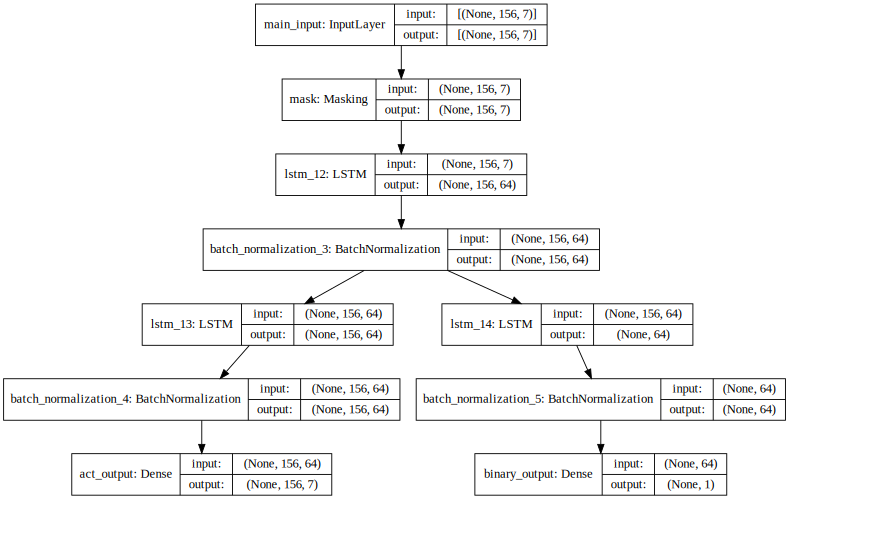

In [ ]:
from IPython.display       import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes = True, show_layer_names = True, dpi=65).create(prog='dot', format='svg'))

In [ ]:
#Fit model
batch_size = 64
epochs = 5
history = model.fit(X_train_new,{'act_output': y_train_new, 'binary_output': y_train_label},
                         validation_data = (X_val_new,{'act_output': y_val_new, 'binary_output': y_val_label}),
                         verbose=1,
                         batch_size=batch_size,
                         epochs=epochs)

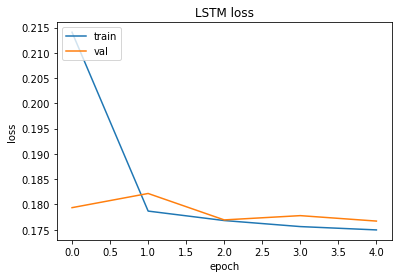

In [ ]:
#Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# model predict
y_pred_act1, y_pred_binary1 = model.predict(X_test_new)

In [ ]:
#save model
model.save('vanilla.h5')

In [ ]:
#load model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/vanilla.h5')

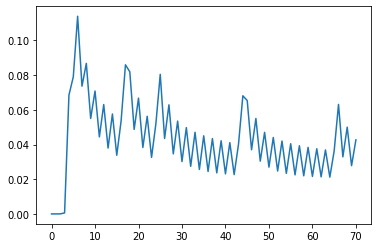

In [ ]:
#Plot probability of exit for one trajectory:
def get_x_y(number):
  one = []
  for item in y_pred_act[number]:
    one.append(item[-1])

  item = [np.argmax(y, axis=None, out=None) for y in X_test_new[number]]
  item = np.ma.masked_equal(item, 0)
  item = item.compressed()
  lol = []
  for e in item:
    lol.append(e)
  x = []
  for i in range(len(lol)):
    x.append(i)

  y = one[-len(lol):]

  return x, y
x, y = get_x_y(9877)
plt.plot(x, y)
plt.show()

In [ ]:
## Time aware Gen and discriminative LSTM
from keras.layers import LSTM, Dense, Masking, Input, BatchNormalization, Lambda
from keras import  Model
from src import TLSTM_layer

main_input = Input(shape = (maxlen - 1, num_classes), name = 'main_input')
mask1 = Masking(mask_value = 0, name = 'mask1' )(main_input)
# delta_ts: (batch_size, 1)
delta_ts = Input(shape=(maxlen -1, ), name='delta_ts')
mask2 = Masking(mask_value = -1, name = 'mask2' )(delta_ts)

l1 = TLSTM_layer(64, return_sequence = True)(mask1, mask2)

# batchnorm shared TLSTM layer output
b1 = keras.layers.BatchNormalization()(l1)

# the layer specialized in time prediction
l2_1 = TLSTM_layer(64, return_sequence = True)(b1, mask2)

# batchnorm activity prediction specialized LSTM
b2_1 = keras.layers.BatchNormalization()(l2_1)

# the layer specialized in binary classification
l2_2a = TLSTM_layer(64)(b1, mask2)
l2_2 = Lambda(lambda x: x[:, -1, :])(l2_2a)

# batchnorm time prediction specialized TLSTM output
b2_2 = keras.layers.BatchNormalization()(l2_2)

#d2_1 = keras.layers.Dropout(rate=hparams[HP_DROPOUT])(b2_1)
#d2_2 = keras.layers.Dropout(rate=hparams[HP_DROPOUT])(b2_2)

act_output = Dense(num_classes, activation = 'softmax', name='act_output')(b2_1)
binary_output = Dense(1, activation = 'sigmoid', name='binary_output')(b2_2)

# define model
time_model = Model(inputs=[main_input, delta_ts], outputs=[act_output, binary_output])

# compile model
time_model.compile(loss={'act_output': 'categorical_crossentropy', 'binary_output': 'binary_crossentropy'},
                      optimizer = 'adam', metrics = ['acc'])
time_model.summary()


Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 156, 7)]     0                                            
__________________________________________________________________________________________________
delta_ts (InputLayer)           [(None, 156)]        0                                            
__________________________________________________________________________________________________
mask1 (Masking)                 (None, 156, 7)       0           main_input[0][0]                 
__________________________________________________________________________________________________
mask2 (Masking)                 (None, 156)          0           delta_ts[0][0]                   
___________________________________________________________________________________________

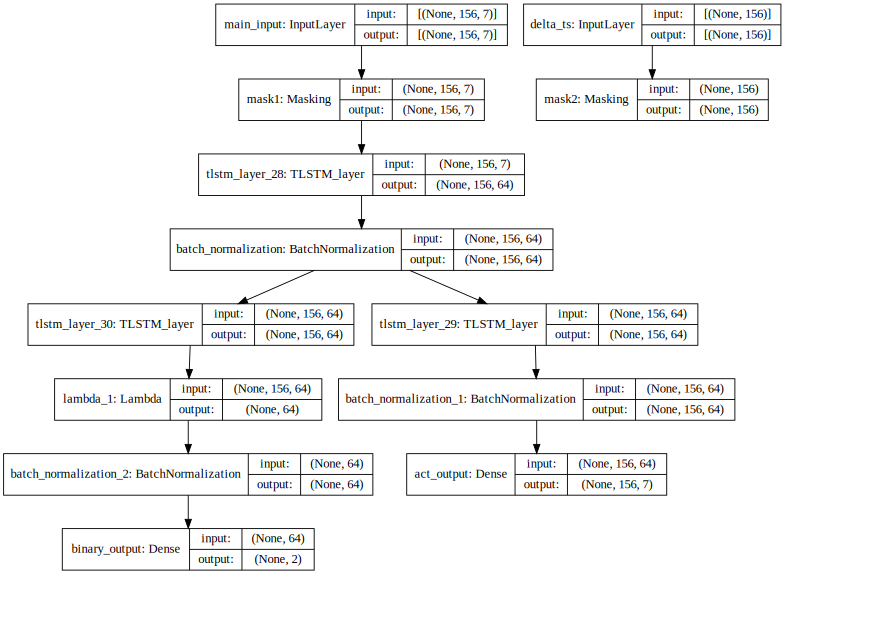

In [ ]:
from IPython.display       import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(time_model, show_shapes = True, show_layer_names = True, dpi=65).create(prog='dot', format='svg'))

In [ ]:
#fit time model
batch_size = 64,
epochs = 5
history_time = time_model.fit([X_train_new, X_train_delta],
                          [y_train_new, y_train_label],
                         validation_data = ([X_val_new, X_val_delta],
                                             [y_val_new, y_val_label]),
                         verbose = 1,
                         batch_size = 64,
                         epochs = epochs)

Epoch 1/5
2222/2222 [==============================] - 1017s 453ms/step - loss: 0.3261 - act_output_loss: 0.1173 - binary_output_loss: 0.2088 - act_output_acc: 0.6872 - binary_output_acc: 0.9275 - val_loss: 0.1861 - val_act_output_loss: 0.1013 - val_binary_output_loss: 0.0848 - val_act_output_acc: 0.7290 - val_binary_output_acc: 0.9648
Epoch 2/5
2222/2222 [==============================] - 1018s 458ms/step - loss: 0.1865 - act_output_loss: 0.1010 - binary_output_loss: 0.0855 - act_output_acc: 0.7263 - binary_output_acc: 0.9642 - val_loss: 0.1940 - val_act_output_loss: 0.1008 - val_binary_output_loss: 0.0932 - val_act_output_acc: 0.7292 - val_binary_output_acc: 0.9617
Epoch 3/5
2222/2222 [==============================] - 1023s 460ms/step - loss: 0.1842 - act_output_loss: 0.0998 - binary_output_loss: 0.0845 - act_output_acc: 0.7281 - binary_output_acc: 0.9640 - val_loss: 0.1808 - val_act_output_loss: 0.1000 - val_binary_output_loss: 0.0809 - val_act_output_acc: 0.7300 - val_binary_outpu

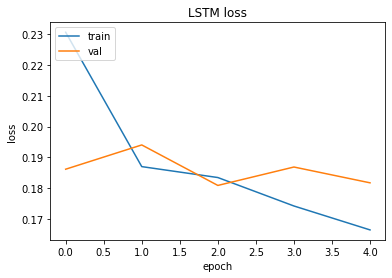

In [ ]:
#Plot loss
plt.plot(history_time.history['loss'])
plt.plot(history_time.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred_act, y_pred_binary = time_model.predict([X_test_new, X_test_delta])

In [ ]:
# save model
time_model.save('time_model_new.h5')

In [ ]:
#load model
time_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Thesis/time_model_new.h5', custom_objects= {'TLSTM_layer':TLSTM_layer})

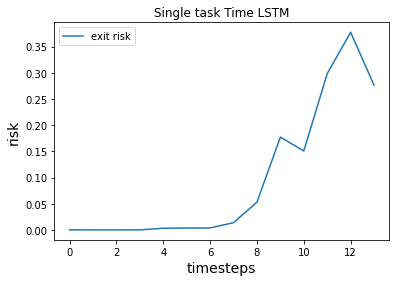

In [ ]:
#Plot probability of exit for one trajectory:
def get_x_y(number):
  one = []
  for item in y_pred_act_TIME_SG[number]:
    one.append(item[-1])

  item = [np.argmax(y, axis=None, out=None) for y in X_test_new[number]]
  item = np.ma.masked_equal(item, 0)
  item = item.compressed()
  lol = []
  for e in item:
    lol.append(e)
  x = []
  for i in range(len(lol)):
    x.append(i)

  y = one[-len(lol):]

  return x, y
x, y = get_x_y(14002)
plt.plot(x, y, label = 'exit risk' )
plt.title('Single task Time LSTM')
plt.xlabel("timesteps", size=14)
plt.ylabel("risk", size=14)
plt.legend(loc=0)
plt.show()

In [ ]:
AUC ROC
from sklearn.metrics import roc_auc_score
print('-----------')
print('AUC ROC')
print('Specialized LSTM')
print(roc_auc_score(y_test_label, y_pred_binary_SD))
print('------------')
print('Multi LSTM')
print(roc_auc_score(y_test_label, y_pred_binary1))
print('------------')
print('Multi Time LSTM')
print(roc_auc_score(y_test_label, y_pred_binary))
print('-------------')
print('single Time LSTM')
print(roc_auc_score(y_test_label, y_pred_binary_TIME_SD))

In [ ]:
#Perplexity
from keras import backend as K
def ppl_e(y_true, y_pred):
    return K.exp(K.mean(K.categorical_crossentropy(y_true, y_pred)))
print('-------------')
print('Time LSTM')
print(ppl_e(y_test_new,y_pred_act))
print('-------------')
print('Multi LSTM')
print(ppl_e(y_test_new,y_pred_act1))
print('--------------')
print('Specialized LSTM')
print(ppl_e(y_test_new,y_pred_act_SG))
print('--------------')
print('Specialized TIME LSTM')
print(ppl_e(y_test_new,y_pred_act_TIME_SG))

-------------
Time LSTM
tf.Tensor(1.1089919, shape=(), dtype=float32)
-------------
Multi LSTM
tf.Tensor(1.1110604, shape=(), dtype=float32)
--------------
Specialized LSTM
tf.Tensor(1.1075435, shape=(), dtype=float32)
--------------
Specialized TIME LSTM
tf.Tensor(1.1062566, shape=(), dtype=float32)


In [ ]:
#ROC CURVE MULTIPLR
from sklearn import metrics
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y_test_label, y_pred_binary_SD)
auc = metrics.roc_auc_score(y_test_label, y_pred_binary_SD)
plt.plot(fpr,tpr,label="LSTM_S")

fpr, tpr, thresh = metrics.roc_curve(y_test_label,y_pred_binary1)
auc = metrics.roc_auc_score(y_test_label, y_pred_binary1)
plt.plot(fpr,tpr,label="Multi-task LSTM")

fpr, tpr, thresh = metrics.roc_curve(y_test_label, y_pred_binary)
auc = metrics.roc_auc_score(y_test_label, y_pred_binary)
plt.plot(fpr,tpr,label="Multi_task T-LSTM")

fpr, tpr, thresh = metrics.roc_curve(y_test_label, y_pred_binary)
auc = metrics.roc_auc_score(y_test_label, y_pred_binary_TIME_SD)
plt.plot(fpr,tpr,label="Multi_task T-LSTM")
plt.xlabel("FPR", size=14)
plt.ylabel("TPR", size=14)
plt.title("ROC curves")
plt.plot([0,1], [0,1], linestyle='--', label='No Skill, auc =0.5')
plt.legend(loc=0)

In [ ]:
#POst-Processsing
#random choice

def make_y_sequences(y_pred_act):
  random_pred = []
  real_pred = []
  for i in range(len(y_pred_act)):
    item = [np.argmax(y, axis=None, out=None) for y in y_test_new[i]]
    item = np.ma.masked_equal(item, 0)
    item = item.compressed()
    real_pred.append(item)
    l = len(item)
    ns = []
    for r in y_pred_act[i][-l:]:
      wow =np.random.choice(r, p=r)
      for i in range(len(r)):
        if r[i] == wow:
          ns.append(i)
    random_pred.append(ns)
  return random_pred, real_pred
random_pred, real_pred = make_y_sequences(y_pred_act)
random_pred1, real_pred = make_y_sequences(y_pred_act1)
random_pred_SG, real_pred = make_y_sequences(y_pred_act_SG)
random_pred_TIME_SG, real_pred = make_y_sequences(y_pred_act_TIME_SG)

In [ ]:
#DL distance from https://stackabuse.com/levenshtein-distance-and-text-similarity-in-python/
import numpy as np

def levenshtein(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    return (matrix[size_x - 1, size_y - 1])

In [ ]:
#distance similarity array
distances = []
distances1 = []
distances_SG = []
distances_TIME_SG = []
for ps, rs in zip(random_pred, real_pred):
    distances.append(levenshtein(ps, rs))
for ps, rs in zip(random_pred1, real_pred):
    distances1.append(levenshtein(ps, rs))
for ps, rs in zip(random_pred_SG, real_pred):
    distances_SG.append(levenshtein(ps, rs))
for ps, rs in zip(random_pred_TIME_SG, real_pred):
    distances_TIME_SG.append(levenshtein(ps, rs))

In [ ]:
# DL mean
print('DL mean')
print('---------')
print('Multi-task TIME lstm')
print(np.mean(distances))
print('---------')
print('Multi-task lstm')
print(np.mean(distances1))
print('---------')
print('Single-task lstm')
print(np.mean(distances_SG))
print('---------')
print('Single-task TIME lstm')
print(np.mean(distances_TIME_SG))


DL mean
---------
Multi-task TIME lstm
6.782096313560713
---------
Multi-task lstm
7.173095230279356
---------
Single-task lstm
7.486951383645734
---------
Single-task TIME lstm
7.025867445753866


In [ ]:
#Plot probability of exit for one trajectory:
def get_x_y(number):
  one = []
  for item in y_pred_act_SG[number]:
    one.append(item[-1])

  item = [np.argmax(y, axis=None, out=None) for y in X_test_new[number]]
  item = np.ma.masked_equal(item, 0)
  item = item.compressed()
  lol = []
  for e in item:
    lol.append(e)
  x = []
  for i in range(len(lol)):
    x.append(i)

  y = one[-len(lol):]

  return x, y
x, y = get_x_y(14002)
plt.plot(x, y, label = 'exit risk' )
plt.title('Single task Time LSTM')
plt.xlabel("timesteps", size=14)
plt.ylabel("risk", size=14)
plt.legend(loc=0)
plt.show()

In [ ]:
#Plot probability of exit for one trajectory:
def get_x_y(number):
  one = []
  for item in y_pred_act[number]:
    one.append(item[-1])

  item = [np.argmax(y, axis=None, out=None) for y in X_test_new[number]]
  item = np.ma.masked_equal(item, 0)
  item = item.compressed()
  lol = []
  for e in item:
    lol.append(e)
  x = []
  for i in range(len(lol)):
    x.append(i)

  y = one[-len(lol):]

  return x, y
x, y = get_x_y(14002)
plt.plot(x, y, label = 'exit risk' )
plt.title('Single task Time LSTM')
plt.xlabel("timesteps", size=14)
plt.ylabel("risk", size=14)
plt.legend(loc=0)
plt.show()

In [ ]:
#Plot probability of exit for one trajectory:
def get_x_y(number):
  one = []
  for item in y_pred_act1[number]:
    one.append(item[-1])

  item = [np.argmax(y, axis=None, out=None) for y in X_test_new[number]]
  item = np.ma.masked_equal(item, 0)
  item = item.compressed()
  lol = []
  for e in item:
    lol.append(e)
  x = []
  for i in range(len(lol)):
    x.append(i)

  y = one[-len(lol):]

  return x, y
x, y = get_x_y(14002)
plt.plot(x, y, label = 'exit risk' )
plt.title('Single task Time LSTM')
plt.xlabel("timesteps", size=14)
plt.ylabel("risk", size=14)
plt.legend(loc=0)
plt.show()

In [ ]:
#---------------END OF CODE---------------------#